# Lab 2: Algorithmic Decision Making 2

In this assignment, you will learn about how to observe and interpret the impact different features have on a machine learning model.
Additionally, you will learn about a real-world controversy with a potentially biased machine learning model.

This assignment is intended to be done collaboratively.  You will work as a group to complete the coding and written portions of this assignment.
However, **each group member will submit a copy of the code** via the autograder and **the group will jointly submit one version of the written portion** via Canvas.

## Part 0: Criminal Recidivism

By its nature, machine learning is uncertain.
This uncertainty can be acceptable in many of the countless domains where machine learning can be useful.
We can excuse a model for returning an irrelevant search result,
or a Pacman AI agent for taking a suboptimal path.
However, there are some domains where mistakes can come at the cost of human pain or suffering.
Domains where the cost of mistakes are so great,
one can question whether we should be using machine learning at all.
In this lab, we will skim the surface of one such domain: criminal recidivism.

### COMPAS

In the US justice system, before you are sentenced, paroled, or the terms of your bail are set
(all steps that may result in incarceration)
a judge or committee is supposed to assess your risk for future crime (nonviolent or violent),
this act of committing future crime is called **criminal recidivism**.
If you are considered low risk you may get more favorable treatment (a lower sentence, early parole, a low bail),
but if you are considered high risk then you get the opposite treatment.
COMPAS is software that was developed to do this risk assessment instead of humans.

As a promising machine learner,
you should already be very cautious about a system that decides whether people will spend more time in jail.
(Especially since we are discussing it during an ethics class.)

The nonprofit organization [ProPublica](https://en.wikipedia.org/wiki/ProPublica)
did a [study on COMPAS](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) and found it to be racist.
ProPublica found that COMPAS was more likely to incorrectly label black defendants as high risk,
and less likely to label white defendants as high risk.
In more precise terms, if COMPAS' predictive task was a binary classification where high risk is the positive label,
black defendants have a higher false positive rate (FPR)
while white defendants have a higher false negative rate (FNR).
NorthPoint, the company that makes COMPAS, responded that the predictive parity between the groups is the same,
and therefore the model is not biased/racist.

What we see here is not so much an argument about the data (or even the model),
but really an argument about what metrics are most appropriate for this situation.
We have already talked about evaluation metrics and how there are [dozens of them](https://scikit-learn.org/stable/modules/model_evaluation.html).
But here we are talking about [fairness metrics](https://en.wikipedia.org/wiki/Fairness_(machine_learning)#Mathematical_formulation_of_group_fairness_definitions)
(measures of how fair a machine learning model is).
Like evaluation metrics, there are many different fairness metrics.
In fact, if we consider fairness to be defined by a metric, then there are at least 14 different definitions of fairness!
To make it even more difficult, it is mathematically impossible to guarantee that all fairness metrics can be satisfied at the same time.

As with many things in machine learning, this situation comes down to trade-offs and expertise.
There is not an automatic way to just say: this is the right fairness metric.
It is up to you as the expert to decide what is the most appropriate set of fairness metrics to use in a specific scenario.
The "right" answer is to usually pick a set of fairness metrics that best fit your scenario
while always keeping in mind how an unfair model can change people's lives.

Here are some resources if you want to read more about the COMPAS controversy:
 - [Wikipedia Entry for the COMPAS Software](https://en.wikipedia.org/wiki/COMPAS_(software))
 - [Lecture Slides that Discuss COMPAS and Fairness](https://web.stanford.edu/class/cs329t/2021/slides/fairness-Week1.pdf)
 - [Initial ProPublica Article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
   - [More Information on ProPublica Methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

Now that we have talked about fairness metrics,
let's take a look at our data for this lab.

<h3 style="color: green; font-size: x-large";>♦ Group Break</h3>

Take a moment to discus the COMPAS controversy.

Some potential things to discuss with your group:
 - Do you believe that ProPublica is correct that the COMPAS model is racist?
 - Do you believe that NorthPoint is correct that the COMPAS model is fair?
 - What are your opinions on using a machine learning model to predict criminal recidivism?

## Part 1: Data and Initial Model

For this lab, we will be using data on criminal recidivism from Broward County in Florida
(this is the same county from which ProPublica gathered data to analyze the COMPAS algorithm).

Each row in the data contains information on one individual who was charged with a crime in Broward County as some point in the past.
Each data instance contains a number of features (described below) for that individual,
and also contains an output value that indicates if that individual went on to recidivate (commit another crime) in the future.

The data has already been mostly cleaned, transformed, and split for you,
and exists in two files:
`recidivism-training-data.csv` which contains training data
and `recidivism-testing-data.csv` which contains testing data.

All attributes have been converted into binary features.
This generally means that continuous values were binarized with a thresholded
(e.g. everything under 0.5 was converted to 0.0 and the rest was converted to 1.0) 
and non-numeric values were [One-Hot encoded](https://en.wikipedia.org/wiki/One-hot).
In One-Hot encoding, we take all the possible values an item can take and assign each possible value an index.
Presence of that value results in a 1, and absence results in a 0.
Essentially, we are turning a list of items into a series of binary columns which ask "Do you have this value?".
The last column (`Recidivate`) is the label:
`0` for an individual that did not recidivate
and `1` for an individual that did recidivate.

### Features

The features for each individual are as follows:

**Juvenile Felony Count** --
A count of the number of felony convictions this individual has as a minor (juvenile).
Originally, this feature was simply an integer value,
but for this assignment it was transformed into a feature with four categorical values representing ranges/bins of counts.
Those bins are:
 - Count = 0
 - Count = 1
 - Count = 2
 - Count >= 3

**Juvenile Misdemeanor Count** --
A count of the number of misdemeanor convictions this individual has as a minor (juvenile).
As with juvenile felony count above, this feature was originally an integer value,
but for this assignment it was transformed into a feature with four categorical values representing
the same ranges/bins of counts as above (namely: 0, 1, 2, >=3).

**Juvenile "Other" Count** --
A count of the number of non-felony/non-misdemeanor convictions this individual has as a minor (juvenile).
Such "other" convictions are less severe than felonies and misdemeanors (i.e., infractions).
This feature was also originally an integer value, but was transformed into a feature with four categorical values
representing the same ranges/bins of counts as above (namely: 0, 1, 2, >=3).

**Prior Convictions Count** --
A count of the total number of prior convictions this individual has had as an adult.
This feature was also originally an integer value,
but was transformed into a feature with four categorical values representing the same ranges/bins of counts as above (namely: 0, 1, 2, >=3).

**Degree of Charge** --
The degree of the current charge that this individual is facing.
The only possible values for this feature are: "felony" or "misdemeanor".

**Description of Charge** --
The type of crime with which the individual is being charged.
Originally, this feature had over 400 possible values, but they were consolidated into one of the following 12 high-level categories:
 - No charge
 - License issue
 - Public disturbance
 - Negligence
 - Drug-related
 - Alcohol-related
 - Weapons-related
 - Evading arrest
 - Nonviolent harm (i.e. stalking, tampering with victim, property damage, etc.)
 - Theft/fraud/burglary
 - Lewdness/prostitution
 - Violent crimes

**Age** --
The individual's age at the time of arrest.
Originally, this feature was simply an integer value,
but for this assignment it was transformed into a feature with three categorical values representing ranges of ages
(to match the same age bins used in the ProPublica analysis for this feature).
Those age ranges/bins are:
 - Less than 25 years old
 - 25 to 45 years old
 - Greater than 45 years old

**Gender** --
The individual's gender.
To match the COMPAS data, this was artificially restricted to "female" and "male".

**Race** --
The individual's race.
This feature has six values:
 - Other (i.e., none of the races below)
 - Asian
 - Native American
 - Caucasian (same as "White" in the ProPublica analysis)
 - Hispanic
 - African-American (same as "Black" in the ProPublica analysis)

Now that we have a basic overview of the data, let's load it and take a look.

In [1]:
# Import all libraries we will need.
# It is good style to make all your imports in the first cell of the notebook.

import random
import traceback

import matplotlib.pyplot
import numpy
import pandas
import sklearn.linear_model
import math

# Set a global seed in case we need some randomness.
random.seed(146)

In [2]:
recidivism_train = pandas.read_csv("recidivism-training-data.csv")
recidivism_test = pandas.read_csv("recidivism-testing-data.csv")

recidivism_train

,Juvenile felony count = 0,Juvenile felony count = 1,Juvenile felony count = 2,Juvenile felony count >= 3,Juvenile misdemeanor count = 0,Juvenile misdemeanor count = 1,Juvenile misdemeanor count = 2,Juvenile misdemeanor count >= 3,Juvenile other offense count = 0,Juvenile other offense count = 1,...,Age > 45,Gender = Female,Gender = Male,Race = Other,Race = Asian,Race = Native American,Race = Caucasian,Race = Hispanic,Race = African American,Recidivate
0,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
1,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
5046,1,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
5047,1,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,1,0,0,1
5048,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,1


Here we can clearly see all the binary features mentioned above,
where 1 is `True` and 0 is `False`.
We can verify the type of each column using `DataFrame.info()`.

In [3]:
recidivism_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Juvenile felony count = 0                   5050 non-null   int64
 1   Juvenile felony count = 1                   5050 non-null   int64
 2   Juvenile felony count = 2                   5050 non-null   int64
 3   Juvenile felony count >= 3                  5050 non-null   int64
 4   Juvenile misdemeanor count = 0              5050 non-null   int64
 5   Juvenile misdemeanor count = 1              5050 non-null   int64
 6   Juvenile misdemeanor count = 2              5050 non-null   int64
 7   Juvenile misdemeanor count >= 3             5050 non-null   int64
 8   Juvenile other offense count = 0            5050 non-null   int64
 9   Juvenile other offense count = 1            5050 non-null   int64
 10  Juvenile other offense count = 2    

<h3 style="color: green; font-size: x-large";>♦ Group Break</h3>

Take a moment to examine the data with your group.

Some potential things to discuss with your group:
 - Why was the data binarized (converted to all 0/1)?
 - Do all of these features seem "fair" to use?
 - Do any features seem like they could be misused or taken advantage of?

As with in Lab 1, let's shuffle our data and then split into features and labels.

In [4]:
recidivism_train = recidivism_train.sample(frac = 1, ignore_index = True, random_state = 146)
recidivism_test = recidivism_test.sample(frac = 1, ignore_index = True, random_state = 146)

def split_features(label_column_name, train, test):
    feature_column_names = list(train.columns)
    feature_column_names.remove(label_column_name)
    
    features_train = train[feature_column_names]
    labels_train = train[label_column_name]
    
    features_test = test[feature_column_names]
    labels_test = test[label_column_name]

    return features_train, labels_train, features_test, labels_test

recidivism_features_train, recidivism_labels_train, recidivism_features_test, recidivism_labels_test = split_features('Recidivate', recidivism_train, recidivism_test)
print("Features and labels split.")

Features and labels split.


Now that we have data, let's just try out an initial model.
A big part of machine learning is exploration and intuition.
So instead of taking too much time theorizing about what the data *could* contain and how a model *could* perform,
sometimes it is best to just try out something simple and see how it goes.

We already have basic experience training and evaluating models from Lab 1,
so let's take the same approach here.
We will start with a simple Logistic Regression model.

In [5]:
classifier = sklearn.linear_model.LogisticRegression()
classifier.fit(recidivism_features_train, recidivism_labels_train)
score = classifier.score(recidivism_features_test, recidivism_labels_test)
print("Initial Logistic Regression Score: ", score)

Initial Logistic Regression Score:  0.6769870609981515


That's an okay score, not great but fine for a first try.
In this assignment, we will not be focusing on how we can improve our prediction score.
Instead, we will be focusing on seeing what features contribute to that score,
and how changing the sets of features we use can affect the model.

In this case, a single score is not good enough (especially accuracy) to see what is happening in our model.
As discussed in Lab 1, choosing evaluation metrics is critical not just to the success of your model,
but also critical to creating ethical models.
We need to see more metrics to see how our model is actually doing.

<h3 style="color: darkorange; font-size: x-large";>★ Task 1.A</h3>

Complete the function below that takes in the output from a classifier (predictions) and true labels,
and returns a dict that contains that following information (see example output below for exact keys):
 - A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
 - Accuracy
 - [Precision](https://en.wikipedia.org/wiki/Precision_and_recall)
 - [Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
 - [F1 Score](https://en.wikipedia.org/wiki/F-score)
 - [False Negative Rate](https://en.wikipedia.org/wiki/False_positives_and_false_negatives#false_negative_rate)
 - [False Positive Rate](https://en.wikipedia.org/wiki/False_positive_rate)

Whenever a computation would divide by zero, use a `numpy.nan`.

Hint:
Aside from the confusion matrix itself, all of these stats can be computed from a confusion matrix.
Therefore, you may find the [sklearn.metrics.confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function useful here.

Example Output:
```json
{
    "confusion_matrix": {
        "tp": 1,
        "fn": 2,
        "fp": 3,
        "tn": 4,
    },
    "accuracy": 0.500,
    "precision": 0.250,
    "recall": 0.333,
    "f1": 0.286,
    "fnr": 0.667,
    "fpr": 0.429,
}
```

In [6]:
import sklearn.metrics


def get_stats(predictions, labels):
    """
    Get scoring stats for the provided predictions and labels.

    Example output:
    {
        "confusion_matrix": {
            "tp": 1,
            "fn": 2,
            "fp": 3,
            "tn": 4,
        },
        "accuracy": 0.500,
        "precision": 0.250,
        "recall": 0.333,
        "f1": 0.286,
        "fnr": 0.667,
        "fpr": 0.429,
    }

    Returns:
        A dict with full scoring information (see above).
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(labels, predictions, labels=[0, 1]).ravel()
    # print(tp, fn, fp, tn)
    accuracy = sklearn.metrics.accuracy_score(labels, predictions)
    precision = sklearn.metrics.precision_score(labels, predictions)
    recall = sklearn.metrics.recall_score(labels, predictions)
    f1 = sklearn.metrics.f1_score(labels, predictions)
    fnr = fn / (fn + tp)  
    fpr = fp / (fp + tn) 

    return {
        "confusion_matrix": {"tp": tp, "fp": fp, "fn": fn, "tn": tn},
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fnr": fnr,
        "fpr": fpr
    }
    # return NotImplemented

def print_stats(stats):
    if (stats is NotImplemented):
        print("Stats have not been implemented.")
        return
        
    stats = stats.copy()

    matrix = stats.pop('confusion_matrix')

    print("Confusion Matrix:")
    print("                Predicted")
    print("               True  | False")
    print("        True  % 3d   | % 3d  " % (matrix['tp'], matrix['fn']))
    print("Actual        -------------")
    print("        False % 3d   | % 3d  " % (matrix['fp'], matrix['tn']))
    print()

    for name, value in stats.items():
        print("%9s: %0.3f" % (name, value))

predictions = classifier.predict(recidivism_features_test)

stats = get_stats(predictions, recidivism_labels_test)
print_stats(stats)

Confusion Matrix:
                Predicted
               True  | False
        True   606   |  360  
Actual        -------------
        False  339   |  859  

 accuracy: 0.677
precision: 0.641
   recall: 0.627
       f1: 0.634
      fnr: 0.373
      fpr: 0.283


Now we can get a much more complete picture of our model's performance.

## Part 2: Logistic Regression and Feature Weights

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) is a great choice for a first classifier to use when exploring data.
Although there will often be better models to use in the end,
Logistic Regression is a strong "all-around" model that is rarely the worst in practice.
Logistic Regression also falls into a family of models called [general linear models](https://en.wikipedia.org/wiki/General_linear_model),
which are easier to interpret than many other families of models (like clustering or non-linear (e.g. neural) models).

General linear models work by applying a function to a linear combination of all features before making a prediction:
$$
\hat{y}(x, b, w) = f( b + w \cdot x )
$$

Where $ b $ is called the "bias" (not to be confused with a ethical/fairness bias),
$ w $ is a vector of weights/coefficients (one for each feature),
and $ f $ is some function that is applied to the result of the linear combinations.
Logistic regression uses the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) for $ f $.
There are a lot of very interesting reasons, benefits, and trade-offs associated with using the logistic function,
but those are outside the scope of this course.
All we need to know about the logistic function for this lab is that it tends to produce values that are close to either $ 0.0 $ or $ 1.0 $.
As we can see below, large values produce a result near $ 1.0 $, and small values produce a result near $ 0.0 $.

<center><img src="logistic.png" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Logistic-curve.svg'>Wikimedia Commons</a>.</center>

Instead of analyzing the logistic function more, what we are really interested in here is $ w $,
the vector of weights (one for each feature).
As we see above, large inputs into the logistic function produce outputs
(in our case these are predictions) close to $ 1.0 $.
Therefore if the linear combination of is large, our Logistic Regression model will predict closer to 1 (true).
We can also look at it like this:

$$
\hat{y}(x, b, w) \sim \sum_{i = 1}^{|x|} w_i * x_i
$$

This means that after training our Logistic Regression model
(which will learn values for $ b $ and $ w $),
we can look at the values of $ w $ to see which features our model prioritizes.

In [7]:
# Train a model.
classifier = sklearn.linear_model.LogisticRegression()
classifier.fit(recidivism_features_train, recidivism_labels_train)

# Output the feature weights.
classifier.coef_

array([[-0.26920755,  0.22199116, -0.33554427,  0.47564809, -0.10477109,
        -0.00097886,  0.51976803, -0.32113065, -0.39934498,  0.43531705,
        -0.51761523,  0.57453059, -0.54630426, -0.29621356,  0.05713926,
         0.87826598,  0.08351629,  0.00937114, -0.3290371 , -0.15096867,
         0.3055176 , -0.079954  ,  0.13549317, -0.42751545,  0.26789622,
         0.01382814,  0.41361468,  0.19705705, -0.17917661, -0.07386761,
         0.62220742, -0.04057788, -0.48874212, -0.07457881,  0.16746624,
        -0.06516445, -0.06194275,  0.04753301,  0.04967797, -0.06805414,
         0.19083779]])

Cool, we can see the weights (also called "coefficients") for our model.
But this dump of numbers is hard to look at alone,
so let's match these weights up to the feature names.

In [8]:
def print_weights(feature_names, weights):
    if ((feature_names is NotImplemented) or (weights is NotImplemented)):
        print("Data is NotImplemented.")
        return
        
    # Pair up weights and feature names so we can sort them.
    pairs = []
    for i in range(len(feature_names)):
        pairs.append((weights[i], feature_names[i]))

    # Sort the pairs with largest value first.
    pairs = list(sorted(pairs, reverse = True))
    
    print("Feature weights: ")
    for (weight, name) in pairs:
        print("    % 0.4f -- %s" % (weight, name))

recidivism_feature_names = list(recidivism_features_train.columns)
# Note that in the above output, coef_ is a 2d array.
recidivism_weights = classifier.coef_[0]

print_weights(recidivism_feature_names, recidivism_weights)

Feature weights: 
     0.8783 -- Prior conviction count >= 3
     0.6222 -- Age < 25
     0.5745 -- Juvenile other offense count >= 3
     0.5198 -- Juvenile misdemeanor count = 2
     0.4756 -- Juvenile felony count >= 3
     0.4353 -- Juvenile other offense count = 1
     0.4136 -- Charge description = nonviolent harm
     0.3055 -- Charge description = public disturbance
     0.2679 -- Charge description = weapons related
     0.2220 -- Juvenile felony count = 1
     0.1971 -- Charge description = theft/fraud/burglary
     0.1908 -- Race = African American
     0.1675 -- Gender = Male
     0.1355 -- Charge description = drug related
     0.0835 -- Charge degree = felony
     0.0571 -- Prior conviction count = 2
     0.0497 -- Race = Caucasian
     0.0475 -- Race = Native American
     0.0138 -- Charge description = evading arrest
     0.0094 -- Charge degree = misdemeanor
    -0.0010 -- Juvenile misdemeanor count = 1
    -0.0406 -- Age >= 25 and <=45
    -0.0619 -- Race = Asian
    

Now we can clearly see how our Logistic Regression model treats each feature.
Features with a large (positive or negative) weight will have more impact on our predictions.
So, our three most impactful features are:
 - `Prior conviction count >= 3` with a weight of 0.8548.
 - `Age < 25` with a weight of 0.5908.
 - `Prior conviction count = 0` with a weight of -0.5688.

As we look at the features,
consider a positive side effect of binarizing our features.
By making sure that all numeric features are 0/1,
we ensured that they are all within the same scale and can be easily compared when looking at their weights.
If we just left each numeric feature alone,
different features could have different domains.
For example, age (in years) and height (in feet) may get similar weights in a hypothetical model,
but age in this case would actually have more impact in our model (since we will generally be an order of magnitude larger than height).

<h3 style="color: green; font-size: x-large";>♦ Group Break</h3>

Take a moment to think about feature weights in a model.

Some potential things to discuss with your group:
 - Is there a limit on what numeric values our features can be?
 - Can positive weights contribute to negative labels (and vice versa)?
 - Can you think of a way general linear models can capture more complex feature interactions?

## Part 3: Feature Selection

Now that we can see the feature weights that make up our model,
let's see how our model changes as we use different subsets of features.

<h3 style="color: darkorange; font-size: x-large";>★ Task 3.A</h3>

Complete the function below that takes a list of feature names, a matching list of feature weights, and some matching information;
and returns a list of feature names that match the given conditions.

Matching Conditions:
 - `lower_than` (default: `numpy.inf`) -- Match features with a weight lower than this value.
 - `higher_than` (default: `-numpy.inf`) -- Match features with a weight higher than this value.
 - `use_and` (default: `True`) -- Use a logical and (conjunction) when matching conditions, otherwise use a logical or (disjunction).

Note the use of `numpy.inf` (positive infinity) and `-numpy.inf` (negative infinity) as default values.
By using the maximum (an minimum) possible values,
everything is included by default.

In [9]:
def select_features_by_weight(feature_names, weights, lower_than = numpy.inf, higher_than = -numpy.inf, use_and = True):
    """
    Take in two matching lists of feature names and weights,
    and return feature names that match the specified criteria.

    Returns:
        A list of matching feature names.
    """
    

    feat_wieghts = zip(feature_names, weights)

    matching_feat = list()
    for tmp_feat, tmp_weight in feat_wieghts:
        lower_val = tmp_weight < lower_than
        higher_val = tmp_weight > higher_than

        if use_and:
            if lower_val and higher_val:
                matching_feat.append(tmp_feat)
        else:
            if lower_val or higher_val:
                matching_feat.append(tmp_feat)

    return matching_feat

    # return NotImplemented

recidivism_positive_features = select_features_by_weight(recidivism_feature_names, recidivism_weights, higher_than = 0.0)
recidivism_positive_features

['Juvenile felony count = 1',
 'Juvenile felony count >= 3',
 'Juvenile misdemeanor count = 2',
 'Juvenile other offense count = 1',
 'Juvenile other offense count >= 3',
 'Prior conviction count = 2',
 'Prior conviction count >= 3',
 'Charge degree = felony',
 'Charge degree = misdemeanor',
 'Charge description = public disturbance',
 'Charge description = drug related',
 'Charge description = weapons related',
 'Charge description = evading arrest',
 'Charge description = nonviolent harm',
 'Charge description = theft/fraud/burglary',
 'Age < 25',
 'Gender = Male',
 'Race = Native American',
 'Race = Caucasian',
 'Race = African American']

Here we can see all the positive features
(features that positively correlate with a positive label).

But what may be more useful is seeing features that have a high magnitude (regardless of sign).
These will be features that have a large influence over our model.

For this lab, we have arbitrarily chosen 0.3 as the threshold for a "large" magnitude for a feature.
There is no theory or validation behind this choice, just intuition.

In [10]:
select_features_by_weight(recidivism_feature_names, recidivism_weights, higher_than = 0.3, lower_than = -0.3, use_and = False)

['Juvenile felony count = 2',
 'Juvenile felony count >= 3',
 'Juvenile misdemeanor count = 2',
 'Juvenile misdemeanor count >= 3',
 'Juvenile other offense count = 0',
 'Juvenile other offense count = 1',
 'Juvenile other offense count = 2',
 'Juvenile other offense count >= 3',
 'Prior conviction count = 0',
 'Prior conviction count >= 3',
 'Charge description = no charge',
 'Charge description = public disturbance',
 'Charge description = alcohol related',
 'Charge description = nonviolent harm',
 'Age < 25',
 'Age > 45']

Now that we can filter out "weak" and "strong" features,
let's build some models around those features.

<h3 style="color: darkorange; font-size: x-large";>★ Task 3.B</h3>

Complete the function below that takes a full dataset and a list of column names to use,
and returns the weights of a trained Logistic Regression model as well as the stats from your `get_stats()` function.

In [11]:
import sklearn.linear_model


def test_subset_features(features_train, labels_train, features_test, labels_test, selected_feature_names):
    """
    Take in all parts of a full dataset,
    and return the weights for a trained model and stats.

    Returns:
        A list of weights from a Logistic Regression classifier trained on the passed in data.
        The stats for this classifier/dataset as computed by `get_stats()`.
    """
    train_data = features_train[selected_feature_names]
    test_data = features_test[selected_feature_names]

    log_model = sklearn.linear_model.LogisticRegression()
    log_model.fit(train_data, labels_train)

    model_weight = log_model.coef_[0]
    predictions = log_model.predict(test_data)

    tmp_stats = get_stats(predictions, labels_test)

    
    return model_weight, tmp_stats
    # return NotImplemented, NotImplemented

weights, stats = test_subset_features(recidivism_features_train, recidivism_labels_train, recidivism_features_test, recidivism_labels_test, recidivism_positive_features)
if (weights is NotImplemented):
    print("Function not implemented.")
else:
    print("Weights: ", weights)
    print_stats(stats)

Weights:  [ 0.48496189  0.72956137  0.6738111   0.90533545  0.98291472  0.48980585
  1.29006414 -0.36648931 -0.42572235  0.43344344  0.32601239  0.41853913
  0.20273738  0.58091289  0.3709      0.75185682  0.21931591  0.15064104
  0.0629155   0.26985735]
Confusion Matrix:
                Predicted
               True  | False
        True   627   |  339  
Actual        -------------
        False  383   |  815  

 accuracy: 0.666
precision: 0.621
   recall: 0.649
       f1: 0.635
      fnr: 0.351
      fpr: 0.320


With this new function, we should be able to test out different feature combinations pretty quickly.
But, we can make an ever more convenient function that puts together everything we have done in this lab.
We will also have this function (optionally) save the stats that it computes in a global variable called `_saved_stats` so that we can access them all later.

In [12]:
# A super-function that puts everything together so we can test quickly!
def test_and_print_subset_features(label_column_name, train, test,
                                   lower_than = numpy.inf, higher_than = -numpy.inf, use_and = True,
                                   override_selected_columns = None,
                                   save_stats_key = None):
    try:
        _test_and_print_subset_features(label_column_name, train, test,
                                        lower_than, higher_than, use_and,
                                        override_selected_columns, save_stats_key)
    except Exception as ex:
        print("Encountered the following exception, have you implemented all the required functions yet?")
        print(traceback.format_exc())

# Use a private(ish) subroutine so we can more easily catch exceptions.
def _test_and_print_subset_features(label_column_name, train, test,
                                    lower_than, higher_than, use_and,
                                    override_selected_columns, save_stats_key):
    features_train, labels_train, features_test, labels_test = split_features(label_column_name, train, test)
                                       
    base_classifier = sklearn.linear_model.LogisticRegression()
    base_classifier.fit(features_train, labels_train)

    if (override_selected_columns is not None):
        selected_columns = override_selected_columns
    else:
        feature_names = list(features_train.columns)
        base_weights = base_classifier.coef_[0]
        selected_columns = select_features_by_weight(feature_names, base_weights, lower_than = lower_than, higher_than = higher_than, use_and = use_and)

    weights, stats = test_subset_features(features_train, labels_train, features_test, labels_test, selected_columns)

    if ((weights is NotImplemented) or (stats is NotImplemented)):
        print("Functions have not been implemented.")
        return

    print_stats(stats)
    print()
    print_weights(selected_columns, weights)

    if (save_stats_key is not None):
        # Do some fancy moves to make sure that _saved_stats is defined and updated outside of this function.
        global _saved_stats
        _saved_stats = globals().get('_saved_stats', None)
        
        if (_saved_stats is None):
            _saved_stats = {}
        _saved_stats[save_stats_key] = stats

    return stats

test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test, save_stats_key = 'all')

Confusion Matrix:
                Predicted
               True  | False
        True   606   |  360  
Actual        -------------
        False  339   |  859  

 accuracy: 0.677
precision: 0.641
   recall: 0.627
       f1: 0.634
      fnr: 0.373
      fpr: 0.283

Feature weights: 
     0.8783 -- Prior conviction count >= 3
     0.6222 -- Age < 25
     0.5745 -- Juvenile other offense count >= 3
     0.5198 -- Juvenile misdemeanor count = 2
     0.4756 -- Juvenile felony count >= 3
     0.4353 -- Juvenile other offense count = 1
     0.4136 -- Charge description = nonviolent harm
     0.3055 -- Charge description = public disturbance
     0.2679 -- Charge description = weapons related
     0.2220 -- Juvenile felony count = 1
     0.1971 -- Charge description = theft/fraud/burglary
     0.1908 -- Race = African American
     0.1675 -- Gender = Male
     0.1355 -- Charge description = drug related
     0.0835 -- Charge degree = felony
     0.0571 -- Prior conviction count = 2
     0.0497

Great,
now we can test collections of features and see their stats all in one call.
With this, we can look into what happens when we use a subset of the features on this dataset.

Let's start with what happens when we only use the larger features?

In [13]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               higher_than = 0.3, lower_than = -0.3, use_and = False,
                               save_stats_key = 'large')

Confusion Matrix:
                Predicted
               True  | False
        True   615   |  351  
Actual        -------------
        False  376   |  822  

 accuracy: 0.664
precision: 0.621
   recall: 0.637
       f1: 0.629
      fnr: 0.363
      fpr: 0.314

Feature weights: 
     1.0967 -- Prior conviction count >= 3
     0.7757 -- Juvenile felony count >= 3
     0.7514 -- Age < 25
     0.7320 -- Juvenile misdemeanor count = 2
     0.5490 -- Juvenile other offense count >= 3
     0.4074 -- Juvenile other offense count = 1
     0.4004 -- Charge description = nonviolent harm
     0.2301 -- Charge description = public disturbance
    -0.0752 -- Juvenile felony count = 2
    -0.2074 -- Juvenile misdemeanor count >= 3
    -0.3425 -- Charge description = no charge
    -0.4401 -- Prior conviction count = 0
    -0.4694 -- Age > 45
    -0.4808 -- Juvenile other offense count = 0
    -0.5217 -- Juvenile other offense count = 2
    -0.5319 -- Charge description = alcohol related


With only the "large" features, we can see that we perform almost as well as the model with all the features (according to accuracy and F1 score).
This is pretty expected, since we used all the most influential features.
Note that the weights for each feature are different in this model because with a different set of features the model has a slightly different learning problem.

It is pretty interesting that our model with only 17 features performed almost as well as the base model with 41 features.
In this case, the number of feature is not too great (to a computer),
but you can imagine that for models with thousands or millions of feature,
removing irrelevant features could be pretty useful.

Now let's try a model with only the large positive features.

In [14]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               higher_than = 0.3,
                               save_stats_key = 'large positive')

Confusion Matrix:
                Predicted
               True  | False
        True   566   |  400  
Actual        -------------
        False  361   |  837  

 accuracy: 0.648
precision: 0.611
   recall: 0.586
       f1: 0.598
      fnr: 0.414
      fpr: 0.301

Feature weights: 
     1.2843 -- Prior conviction count >= 3
     1.0294 -- Juvenile other offense count >= 3
     0.9616 -- Juvenile other offense count = 1
     0.8638 -- Age < 25
     0.8619 -- Juvenile misdemeanor count = 2
     0.7593 -- Juvenile felony count >= 3
     0.4928 -- Charge description = nonviolent harm
     0.2404 -- Charge description = public disturbance


Once again, we did pretty well.
Not as well as the base model or "large" model,
but pretty close with just a handful of the features.

What about if we use the large negative features?

In [15]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               lower_than = -0.3,
                               save_stats_key = 'large negative')

Confusion Matrix:
                Predicted
               True  | False
        True   587   |  379  
Actual        -------------
        False  422   |  776  

 accuracy: 0.630
precision: 0.582
   recall: 0.608
       f1: 0.594
      fnr: 0.392
      fpr: 0.352

Feature weights: 
     0.2861 -- Juvenile felony count = 2
     0.1932 -- Juvenile misdemeanor count >= 3
    -0.3460 -- Charge description = no charge
    -0.5557 -- Age > 45
    -0.7598 -- Juvenile other offense count = 2
    -0.7752 -- Charge description = alcohol related
    -0.9175 -- Prior conviction count = 0
    -1.1411 -- Juvenile other offense count = 0


Interestingly, we did slightly better than the large positive features.
Perhaps not better enough to be considered significant, but still a little better.
But, we can also say that these large negative features did about the same as the large positive features.

What if we only used "small" features?

In [16]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               higher_than = -0.3, lower_than = 0.3,
                               save_stats_key = 'small')

Confusion Matrix:
                Predicted
               True  | False
        True   453   |  513  
Actual        -------------
        False  328   |  870  

 accuracy: 0.611
precision: 0.580
   recall: 0.469
       f1: 0.519
      fnr: 0.531
      fpr: 0.274

Feature weights: 
     0.4261 -- Race = African American
     0.3898 -- Gender = Male
     0.3622 -- Charge description = theft/fraud/burglary
     0.3544 -- Charge description = weapons related
     0.3327 -- Charge description = drug related
     0.3278 -- Race = Native American
     0.3228 -- Charge degree = felony
     0.2178 -- Juvenile felony count = 1
     0.1675 -- Charge description = evading arrest
     0.0990 -- Charge degree = misdemeanor
     0.0975 -- Charge description = license issue
     0.0779 -- Race = Caucasian
     0.0320 -- Gender = Female
     0.0189 -- Age >= 25 and <=45
     0.0061 -- Charge description = violent crime
    -0.0075 -- Charge description = negligence
    -0.0389 -- Race = Hispanic
    -

As expected, this model was the worst of them all.

<h3 style="color: green; font-size: x-large";>♦ Group Break</h3>

Take a moment to think about the performance of our model with different sets of features.

Some potential things to discuss with your group:
 - Is there any reason we would just not use all the features?
 - Are either the positive or negative features better than the other?
 - Could a feature weight switch from positive to negative (or vice versa) between the base model with all the features and a model with only a subset of the features?

### Protected Attributes

["Protected Attributes"](https://en.wikipedia.org/wiki/Protected_group) generally refer to attributes/features that should not be used to make decisions.
There are specific organizations and situations where certain attributes are legally protected.
For example, in the US it is considered discrimination to not hire someone based on their age, gender, race,
and other attributes (the exact set of attributes may be debated on a state-by-state basis).

Let's collect some protected attributes for our dataset.

In [17]:
protected_keywords = ['age', 'gender', 'race']

protected_columns = []
for column_name in recidivism_features_train.columns:
    match = False
    for protected_keyword in protected_keywords:
        if (protected_keyword in column_name.lower()):
            match = True
            break

    if (match):
        protected_columns.append(column_name)

non_protected_columns = list(set(recidivism_features_train.columns) - set(protected_columns))

print("Protected Columns:")
print("    " + "\n    ".join(protected_columns))
print()
print("Non-Protected Columns:")
print("    " + "\n    ".join(non_protected_columns))

Protected Columns:
    Age < 25
    Age >= 25 and <=45
    Age > 45
    Gender = Female
    Gender = Male
    Race = Other
    Race = Asian
    Race = Native American
    Race = Caucasian
    Race = Hispanic
    Race = African American

Non-Protected Columns:
    Charge description = lewdness/prostitution
    Charge description = no charge
    Juvenile felony count >= 3
    Charge description = evading arrest
    Charge description = alcohol related
    Juvenile other offense count = 2
    Juvenile felony count = 1
    Charge description = weapons related
    Juvenile other offense count = 1
    Charge degree = felony
    Juvenile misdemeanor count = 1
    Juvenile other offense count >= 3
    Prior conviction count = 0
    Juvenile misdemeanor count >= 3
    Prior conviction count >= 3
    Juvenile felony count = 2
    Juvenile felony count = 0
    Juvenile other offense count = 0
    Juvenile misdemeanor count = 2
    Juvenile misdemeanor count = 0
    Charge description = drug relat

Now that we have protected (and non-protected) features,
let's see what happens when we remove all protected features?

In [18]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               override_selected_columns = non_protected_columns,
                               save_stats_key = 'non-protected')

Confusion Matrix:
                Predicted
               True  | False
        True   563   |  403  
Actual        -------------
        False  356   |  842  

 accuracy: 0.649
precision: 0.613
   recall: 0.583
       f1: 0.597
      fnr: 0.417
      fpr: 0.297

Feature weights: 
     0.8317 -- Prior conviction count >= 3
     0.7526 -- Juvenile other offense count >= 3
     0.6530 -- Juvenile misdemeanor count = 2
     0.6117 -- Juvenile felony count >= 3
     0.5524 -- Juvenile other offense count = 1
     0.4745 -- Charge description = weapons related
     0.4282 -- Charge description = nonviolent harm
     0.3529 -- Charge description = public disturbance
     0.3408 -- Juvenile felony count = 1
     0.3269 -- Charge description = theft/fraud/burglary
     0.2256 -- Charge degree = felony
     0.2008 -- Charge description = drug related
     0.1519 -- Juvenile misdemeanor count = 1
     0.1360 -- Charge degree = misdemeanor
     0.1332 -- Prior conviction count = 2
     0.0753 --

Interestingly, we see almost the same performance as when we used large positive features.
So as long as none of our features are [proxies for protected attributes](https://towardsdatascience.com/algorithm-fairness-sources-of-bias-7082e5b78a2c),
we can remove all protected features from our model without substantially hurting performance.

Now what happens when we remove all protected features?

In [19]:
test_and_print_subset_features('Recidivate', recidivism_train, recidivism_test,
                               override_selected_columns = protected_columns,
                               save_stats_key = 'protected')

Confusion Matrix:
                Predicted
               True  | False
        True   530   |  436  
Actual        -------------
        False  411   |  787  

 accuracy: 0.609
precision: 0.563
   recall: 0.549
       f1: 0.556
      fnr: 0.451
      fpr: 0.343

Feature weights: 
     0.3882 -- Race = African American
     0.3443 -- Age < 25
     0.1835 -- Race = Native American
     0.1031 -- Gender = Male
     0.0134 -- Race = Caucasian
    -0.0619 -- Age >= 25 and <=45
    -0.2099 -- Race = Hispanic
    -0.2372 -- Race = Other
    -0.3583 -- Gender = Female
    -0.3932 -- Race = Asian
    -0.5375 -- Age > 45


This version of the model does not do well at all.
Not only are the accuracy worse than most of the versions we have seen,
but the F1 is way worse and false negative rate is way higher (which is bad).

It can be hard to remember all these numbers, so let's make a function to help is plot bar graphs of the results.

In [20]:
# See https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def plot_bar(groups, data, title, x_label, y_label,
             y_min = 0.0, y_max = 1.0,
             round_digits = 3,
             sort_keys = None, sort_reverse = True,
             width_in = 14, height_in = 6):
    x = numpy.arange(len(groups))
    width = 1.0 / (len(data) + 1)
    multiplier = 0

    data = data.copy()
    
    matplotlib.pyplot.subplots(layout = 'constrained')

    if (sort_keys is not None):
        sort_pairs = []
        for index in range(len(groups)):
            pair = []
            for sort_key in sort_keys:
                pair.append(data[sort_key][index])

            pair.append(index)
            sort_pairs.append(pair)

        sort_pairs.sort(reverse = sort_reverse)

        new_data = {}
        for (name, values) in data.items():
            new_data[name] = []
            for pair in sort_pairs:
                new_data[name].append(data[name][pair[-1]])

        data = new_data

    if (round_digits is not None):
        for name in data:
            for i in range(len(data[name])):
                data[name][i] = round(data[name][i], round_digits)
        
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = matplotlib.pyplot.bar(x + offset, measurement, width, label = attribute)
        matplotlib.pyplot.bar_label(rects, padding = 10)
        multiplier += 1
    
    matplotlib.pyplot.xlabel(x_label)
    matplotlib.pyplot.ylabel(y_label)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.xticks(x + (width * ((len(data) / 2) - 0.5)), groups)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.ylim(y_min, y_max)
                 
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(width_in, height_in)
    
    matplotlib.pyplot.show()

Now we can use all the stats we have computed and saved (in `_saved_stats`) to plot our results in one place.

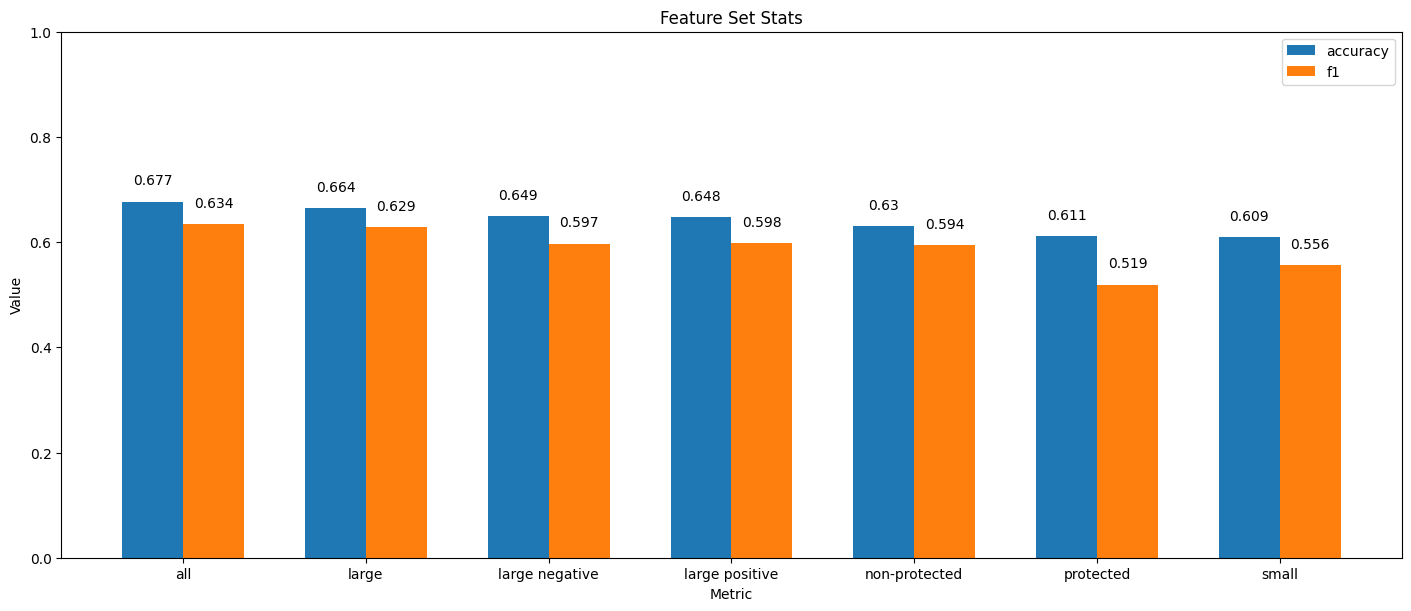

In [21]:
_saved_stats = globals().get('_saved_stats', None)
if (_saved_stats is None):
    print("No stats have been saved.")
else:
    names = list(sorted(_saved_stats.keys()))
    data = {
        'accuracy': [_saved_stats[name]['accuracy'] for name in names],
        'f1': [_saved_stats[name]['f1'] for name in names],
    }
    sort_keys = ['accuracy', 'f1']
    
    plot_bar(names, data, 'Feature Set Stats', 'Metric', 'Value',
             sort_keys = sort_keys, round_digits = 3)

This is interesting, but is still missing parts of the story.
Recall from Lab 1 that we also discussed FNR and FPR.
How do those types of errors work here?

Let's graph them as well.

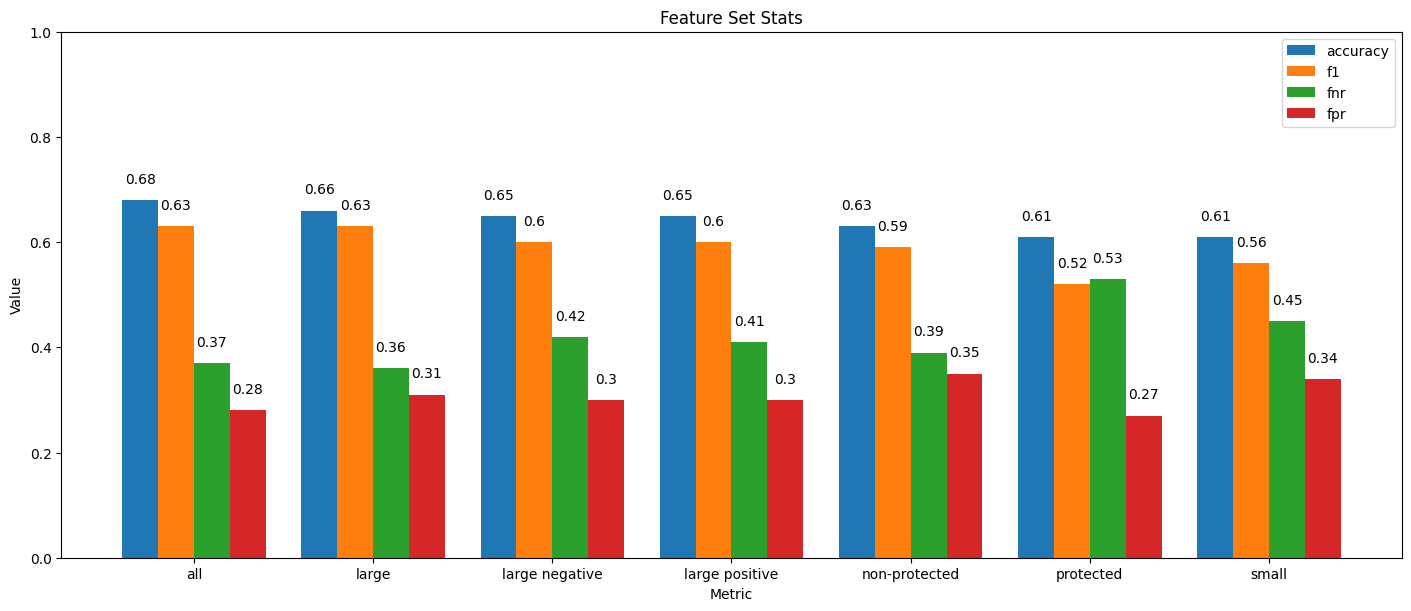

In [22]:
_saved_stats = globals().get('_saved_stats', None)
if (_saved_stats is None):
    print("No stats have been saved.")
else:
    names = list(sorted(_saved_stats.keys()))
    data = {
        'accuracy': [_saved_stats[name]['accuracy'] for name in names],
        'f1': [_saved_stats[name]['f1'] for name in names],
        'fnr': [_saved_stats[name]['fnr'] for name in names],
        'fpr': [_saved_stats[name]['fpr'] for name in names],
    }
    sort_keys = ['accuracy', 'f1']
    
    plot_bar(names, data, 'Feature Set Stats', 'Metric', 'Value',
             sort_keys = sort_keys, round_digits = 2)

Very interesting!
There is a lot to break down in these graphs.
Remember that high accuracy and F1 is good,
but high FNR and FPR is bad.

<h3 style="color: green; font-size: x-large";>♦ Group Break</h3>

Take a moment to think about the performance of our model with different sets of features.

Some potential things to discuss with your group:
 - What insights (if any) can you extract from the graphs above?
 - Using the protected attributes clearly shows that there is a problem not seen in the other feature sets. What could explain this?
 - In this dataset, do we need protected attributes?
     - Should the protected attributes even be included in our model?
     - Why were they included in the COMPAS data?
 - What type of error (False Negative vs False Positive) is more harmful in this setting?

## Part 4: Short Response Questions

Please go to Canvas to enter your group's responses to the following questions.

#### Q1

The data we used includes protected attributes.
Does that mean that the base model we created from it (using all the features) is inherently biased?
Can you prove that model using all the data is or is not biased?

#### Q2

In this dataset, we saw that using only non-protected attributes only slightly impacted our performance metrics.
Assuming that the differences we saw are statistically significant,
do we need to protected attributes?

Justify your answer.

#### Q3

If using protected attributes did create a substantially better model
(and there were no legal issues),
should we include the protected attributes in our model?

Justify your answer.

#### Q4

Can data that has no protected attributes still be biased?
Why or why not.

#### Q5

What type of error (False Negative vs False Positive) is more harmful in this setting?

Justify your answer.

#### Q6

After doing this lab, what are your views on the COMPAS model with respect to bias and racism?

Do you believe that a machine learning model should be used to predict criminal recidivism?
Why or why not?
Does the context matter?